In [1]:
import os
import joblib
import pickle
import numpy as np
import tensorflow as tf
import support_functions as sf
import matplotlib.pyplot as plt
import keras.layers as layers
import sklearn.model_selection as model_selection

from glob import glob
from IPython import display
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from keras import Sequential, Model
from keras.callbacks import Callback

In [2]:
# GPU
sf.limit_gpu_memory(8 * 1024)
sf.gpu_check()

True

## Business Understanding
Bij het trainen van een model zijn de effecten meestal niet direct zichtbaar na de eerste 5 epochs. Grote verschillen zijn meestal pas na grotere tijdsintervallen te zien. Om die reden is het goed om te experimenteren met verschillende modelopstellingen op grotere schaal.

In Medium_Training_2.ipynb is te zien dat het toevoegen van de activatie functie 'relu' toe te voegen een groot succes was. Dit succes wordt in dit notebook verder uitgeplozen. De trainingsopstelling blijft hier hetzelfde als die van Medium_Training_2.ipynb. Deze is als volgt:

Learning rate: 0.001

Analyser:

    Conv2D,
    Conv2D,
    Conv2D,
    MaxPooling2D,
    
    Conv2D,
    Conv2D,
    Conv2D,
    MaxPooling2D
    
    Conv2D,
    Conv2D,
    Conv2D,
    MaxPooling2D,
    
Reconstructor:

    Conv2DTranspose,
    Conv2DTranspose,
    Conv2DTranspose,
    Conv2D

In dit notebook wordt er gekeken naar de verschillen op het moment dat NUMBER_OF_SWITCHES wordt teruggebracht van 15 naar 10. Dit houdt in dat het aantal swaps van patches van een slice wordt verlaagd. Deze actie zal het waarschijnlijk op korte termijn makkelijker maken voor het model, aangezien het minder gecorrumpeerde gebieden hoeft te reconstruëren. Echter, op langer termijn zou het wellicht voor een slechter begrip bij een CT-Scan leiden. Dit is iets om goed in het achterhoofd te houden.

---
#### Dit notebook is opgebouwd uit de volgende bronnen:
- N02. Inlezen data (loading) v3.0.ipynb van Chula Bruggeling (Data Understanding)
- read_dicom_files.ipynb van Dr. Paul Hiemstra (Data Understanding)
- split_models.ipynb van Vincent Dorenbosch (Data Preperation)
- split_models.ipynb van Vincent Dorenbosch (Modelling)
- Grote_Training.ipynb van Youri de Beurs (Modelling)
- Medium_Training.ipynb van Youri de Beurs (Modelling)
- Medium_Training_2.ipynb van Youri de Beurs (Modelling)
- triplets.ipynb van Hein Kamphuis (Evaluation)
- Trainings_Video.ipynb van Youri de Beurs (Evaluation)

## Data preparation

In [3]:
# Read slices
SLICES_JOBLIB_PATH = os.path.join('scans','scans_max_normalised_float32.joblib')

slices = joblib.load(SLICES_JOBLIB_PATH)

In [4]:
# Corrupt scans
NUMBER_OF_SWITCHES = 15
PATCH_SIZE = 32

corrupted_slices = np.array([sf.corrupt_image(slice, NUMBER_OF_SWITCHES, PATCH_SIZE) for slice in slices])

In [5]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(corrupted_slices, slices, test_size=0.2)

X_train = np.resize(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
y_train = np.resize(y_train, (y_train.shape[0], y_train.shape[1], y_train.shape[2], 1))

X_test = np.resize(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))
y_test = np.resize(y_test, (y_test.shape[0], y_test.shape[1], y_test.shape[2], 1))

## Modelling

In [6]:
# Use mulitple GPU's
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [7]:
with strategy.scope():
    analyzer = Sequential(
        [
            layers.Conv2D(128, kernel_size=3, input_shape=(512,512,1), padding='same', activation='relu'),
            layers.Conv2D(128, kernel_size=3, padding='same', activation='relu'),
            layers.Conv2D(128, kernel_size=3, padding='same', activation='relu'),
            layers.MaxPooling2D(),

            layers.Conv2D(256, kernel_size=3, padding='same', activation='relu'),
            layers.Conv2D(256, kernel_size=3, padding='same', activation='relu'),
            layers.Conv2D(256, kernel_size=3, padding='same', activation='relu'),
            layers.MaxPooling2D(),
            
            layers.Conv2D(256, kernel_size=3, padding='same', activation='relu'),
            layers.Conv2D(256, kernel_size=3, padding='same', activation='relu'),
            layers.Conv2D(256, kernel_size=3, padding='same', activation='relu'),
            layers.MaxPooling2D(),
        ],
        name="analyzer",
    )
    analyzer.summary()

Model: "analyzer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 512, 512, 128)     1280      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 512, 512, 128)     147584    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 512, 512, 128)     147584    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 256, 256, 128)     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 256, 256, 256)     295168    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 256, 256, 256)     590080    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 256, 256, 256)     590

In [8]:
with strategy.scope():
    reconstructor = Sequential(
        [
            layers.Conv2DTranspose(512, kernel_size=3, strides=2, padding='same', input_shape=(64, 64, 256), activation='relu'),
            layers.Conv2DTranspose(256, kernel_size=3, strides=2, padding='same', activation='relu'),
            layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding='same', activation='relu'),
            layers.Conv2D(1, kernel_size=3, padding='same', activation='relu'),
        ],
        name="reconstructor",
    )
    reconstructor.summary()

Model: "reconstructor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose (Conv2DTran (None, 128, 128, 512)     1180160   
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 256, 256, 256)     1179904   
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 512, 512, 128)     295040    
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 512, 512, 1)       1153      
Total params: 2,656,257
Trainable params: 2,656,257
Non-trainable params: 0
_________________________________________________________________


In [9]:
with strategy.scope():
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    
    out_analyzer = analyzer.output
    out_final = reconstructor(out_analyzer)
    model = Model(analyzer.input, out_final)
    
    model.compile(optimizer=opt, loss='mse')

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


In [ ]:
MODEL_NAME = 'groot_model_LR_0.001_3'
CALLBACK_INTERVAL = 5

model_folder = os.path.join('models', MODEL_NAME)
os.makedirs(model_folder, exist_ok=True)

image = y_train[0]
image_corrupt = sf.corrupt_image(image, NUMBER_OF_SWITCHES, PATCH_SIZE)
image_corrupt_expanded = np.resize(image_corrupt, (1, image_corrupt.shape[0], image_corrupt.shape[1], 1))

plt.imsave(os.path.join(model_folder, 'image.png'), np.resize(image, (image.shape[0], image.shape[1])), cmap=plt.cm.gray)
plt.imsave(os.path.join(model_folder, 'image_corrupt.png'), np.resize(image_corrupt, (image_corrupt.shape[0], image_corrupt.shape[1])), cmap=plt.cm.gray)

class PredictionCallback(Callback):    
  def on_epoch_end(self, epoch, logs={}):
    if (epoch % CALLBACK_INTERVAL == 0):
        image_predict = model.predict(image_corrupt_expanded)[0]
        sf.display_triplets(image, image_corrupt, image_predict)
        
        image_path = os.path.join(model_folder, f'{epoch:06d}.png')
        plt.imsave(image_path, np.resize(image_predict, (image_predict.shape[0], image_predict.shape[1])), cmap=plt.cm.gray)
        
class ModelSaveCallback(Callback):    
  def on_epoch_end(self, epoch, logs={}):
    if (epoch % CALLBACK_INTERVAL == 0):
        analyzer.save(os.path.join(model_folder, 'analyzer.h5'))
        reconstructor.save(os.path.join(model_folder, 'reconstructor.h5'))
        model.save(os.path.join(model_folder, 'complete.h5'))
        

custom_callbacks = [
    PredictionCallback(),
    ModelSaveCallback()
]

Epoch 1/500
INFO:tensorflow:batch_all_reduce: 26 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 26 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
51/51 [==============================] - ETA: 0s - loss: 0.0318INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/ta

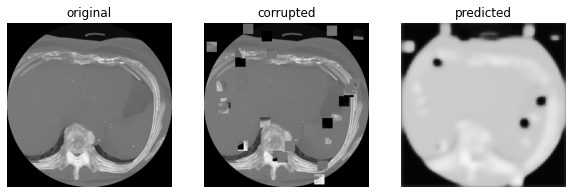

Epoch 2/500
51/51 [==============================] - 17s 329ms/step - loss: 0.0043 - val_loss: 0.0037
Epoch 3/500
51/51 [==============================] - 17s 329ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 4/500
51/51 [==============================] - 17s 332ms/step - loss: 0.0027 - val_loss: 0.0024
Epoch 5/500
51/51 [==============================] - 17s 331ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 6/500
51/51 [==============================] - 17s 331ms/step - loss: 0.0016 - val_loss: 0.0016


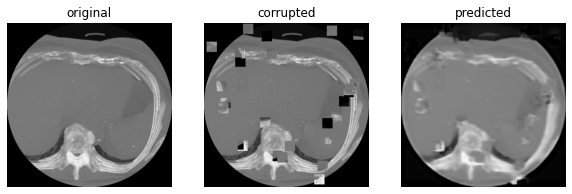

Epoch 7/500
51/51 [==============================] - 17s 332ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 8/500
51/51 [==============================] - 17s 332ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 9/500
51/51 [==============================] - 17s 333ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 10/500
51/51 [==============================] - 17s 333ms/step - loss: 0.0010 - val_loss: 0.0012
Epoch 11/500
51/51 [==============================] - 17s 333ms/step - loss: 9.6317e-04 - val_loss: 0.0010


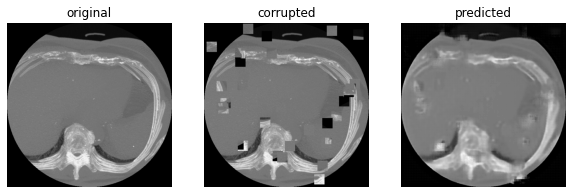

Epoch 12/500
51/51 [==============================] - 17s 333ms/step - loss: 9.9132e-04 - val_loss: 0.0010
Epoch 13/500
51/51 [==============================] - 17s 333ms/step - loss: 8.4231e-04 - val_loss: 8.9048e-04
Epoch 14/500
51/51 [==============================] - 17s 334ms/step - loss: 7.6090e-04 - val_loss: 8.5633e-04
Epoch 15/500
51/51 [==============================] - 17s 334ms/step - loss: 7.2258e-04 - val_loss: 8.6093e-04
Epoch 16/500
51/51 [==============================] - 17s 333ms/step - loss: 7.0091e-04 - val_loss: 9.7288e-04


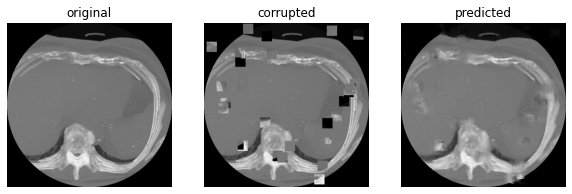

Epoch 17/500
51/51 [==============================] - 17s 333ms/step - loss: 7.2433e-04 - val_loss: 8.0298e-04
Epoch 18/500
51/51 [==============================] - 17s 334ms/step - loss: 5.9451e-04 - val_loss: 8.0556e-04
Epoch 19/500
51/51 [==============================] - 17s 333ms/step - loss: 5.7434e-04 - val_loss: 7.3654e-04
Epoch 20/500
51/51 [==============================] - 17s 333ms/step - loss: 5.4088e-04 - val_loss: 7.1482e-04
Epoch 21/500
51/51 [==============================] - 17s 333ms/step - loss: 5.5445e-04 - val_loss: 9.4056e-04


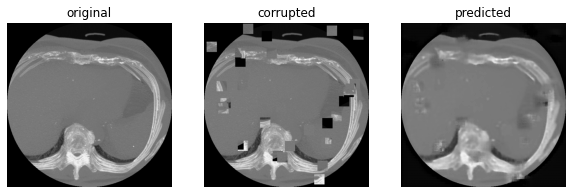

Epoch 22/500
51/51 [==============================] - 17s 333ms/step - loss: 5.5757e-04 - val_loss: 7.1986e-04
Epoch 23/500
51/51 [==============================] - 17s 333ms/step - loss: 4.7707e-04 - val_loss: 6.5907e-04
Epoch 24/500
51/51 [==============================] - 17s 334ms/step - loss: 4.4491e-04 - val_loss: 6.7346e-04
Epoch 25/500
51/51 [==============================] - 17s 333ms/step - loss: 4.2257e-04 - val_loss: 6.4698e-04
Epoch 26/500
51/51 [==============================] - 17s 336ms/step - loss: 4.1741e-04 - val_loss: 6.4743e-04


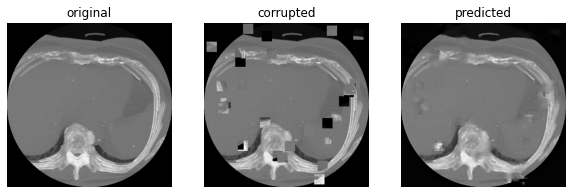

Epoch 27/500
51/51 [==============================] - 17s 333ms/step - loss: 3.9745e-04 - val_loss: 6.2979e-04
Epoch 28/500
51/51 [==============================] - 17s 333ms/step - loss: 4.2416e-04 - val_loss: 0.0022
Epoch 29/500
51/51 [==============================] - 17s 332ms/step - loss: 0.0090 - val_loss: 0.0596
Epoch 30/500
51/51 [==============================] - 17s 332ms/step - loss: 0.0061 - val_loss: 0.0039
Epoch 31/500
51/51 [==============================] - 17s 332ms/step - loss: 0.0030 - val_loss: 0.0022


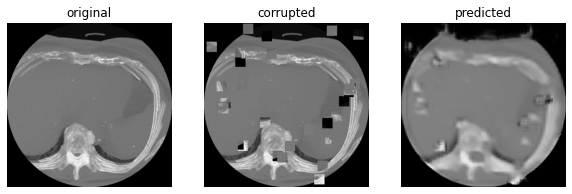

Epoch 32/500
51/51 [==============================] - 17s 332ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 33/500
51/51 [==============================] - 17s 332ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 34/500
51/51 [==============================] - 17s 331ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 35/500
51/51 [==============================] - 17s 332ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 36/500
51/51 [==============================] - 17s 331ms/step - loss: 0.0012 - val_loss: 0.0015


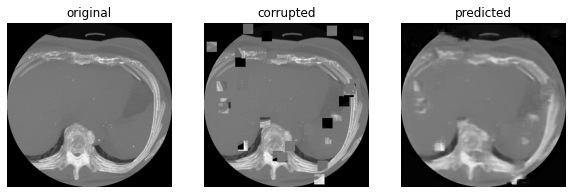

Epoch 37/500
51/51 [==============================] - 17s 332ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 38/500
51/51 [==============================] - 17s 332ms/step - loss: 9.9760e-04 - val_loss: 0.0011
Epoch 39/500
51/51 [==============================] - 17s 332ms/step - loss: 9.5655e-04 - val_loss: 0.0011
Epoch 40/500
51/51 [==============================] - 17s 332ms/step - loss: 9.0471e-04 - val_loss: 0.0011
Epoch 41/500
51/51 [==============================] - 17s 333ms/step - loss: 9.0109e-04 - val_loss: 0.0011


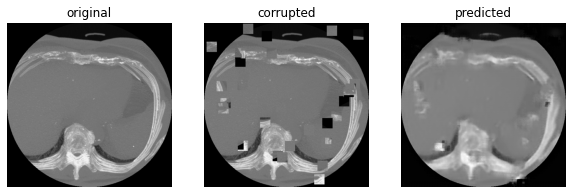

Epoch 42/500
51/51 [==============================] - 17s 332ms/step - loss: 8.5252e-04 - val_loss: 9.7871e-04
Epoch 43/500
51/51 [==============================] - 17s 333ms/step - loss: 8.0281e-04 - val_loss: 9.7935e-04
Epoch 44/500
51/51 [==============================] - 17s 332ms/step - loss: 7.9322e-04 - val_loss: 0.0010
Epoch 45/500
51/51 [==============================] - 17s 332ms/step - loss: 7.5947e-04 - val_loss: 9.5480e-04
Epoch 46/500
51/51 [==============================] - 17s 331ms/step - loss: 7.3398e-04 - val_loss: 9.2844e-04


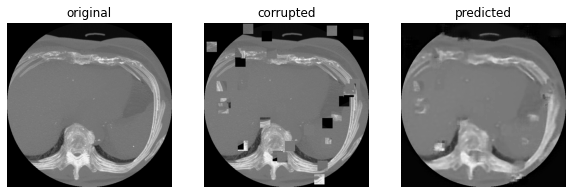

Epoch 47/500
51/51 [==============================] - 17s 332ms/step - loss: 7.0668e-04 - val_loss: 9.2619e-04
Epoch 48/500
51/51 [==============================] - 17s 332ms/step - loss: 6.8199e-04 - val_loss: 8.7526e-04
Epoch 49/500
51/51 [==============================] - 17s 332ms/step - loss: 6.7392e-04 - val_loss: 8.8713e-04
Epoch 50/500
51/51 [==============================] - 17s 332ms/step - loss: 6.2298e-04 - val_loss: 8.5534e-04
Epoch 51/500
51/51 [==============================] - 17s 333ms/step - loss: 6.0744e-04 - val_loss: 8.3532e-04


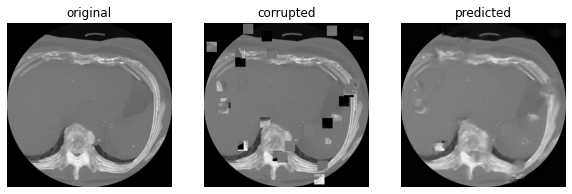

Epoch 52/500
51/51 [==============================] - 17s 333ms/step - loss: 5.9600e-04 - val_loss: 8.2850e-04
Epoch 53/500
51/51 [==============================] - 17s 332ms/step - loss: 5.7351e-04 - val_loss: 8.2888e-04
Epoch 54/500
51/51 [==============================] - 17s 331ms/step - loss: 5.5483e-04 - val_loss: 8.2486e-04
Epoch 55/500
51/51 [==============================] - 17s 332ms/step - loss: 5.4109e-04 - val_loss: 8.2601e-04
Epoch 56/500
51/51 [==============================] - 17s 332ms/step - loss: 5.3151e-04 - val_loss: 7.8553e-04


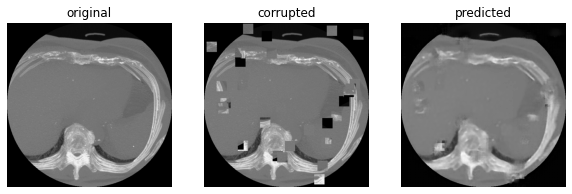

Epoch 57/500
51/51 [==============================] - 17s 333ms/step - loss: 5.1780e-04 - val_loss: 7.6973e-04
Epoch 58/500
51/51 [==============================] - 17s 332ms/step - loss: 4.9508e-04 - val_loss: 7.7080e-04
Epoch 59/500
51/51 [==============================] - 17s 333ms/step - loss: 4.7705e-04 - val_loss: 7.8133e-04
Epoch 60/500
51/51 [==============================] - 17s 331ms/step - loss: 5.5365e-04 - val_loss: 7.7993e-04
Epoch 61/500
51/51 [==============================] - 17s 331ms/step - loss: 4.8206e-04 - val_loss: 8.6694e-04


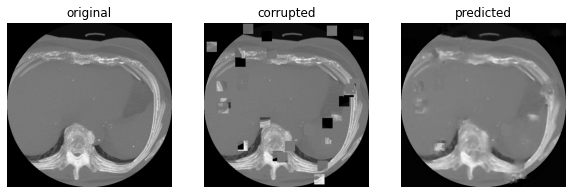

Epoch 62/500
51/51 [==============================] - 17s 332ms/step - loss: 4.8697e-04 - val_loss: 7.6453e-04
Epoch 63/500
51/51 [==============================] - 17s 332ms/step - loss: 4.7617e-04 - val_loss: 7.3181e-04
Epoch 64/500
51/51 [==============================] - 17s 332ms/step - loss: 4.2966e-04 - val_loss: 7.4859e-04
Epoch 65/500
42/51 [=======================>......] - ETA: 2s - loss: 4.2774e-04

In [ ]:
history = model.fit(X_train, y_train, epochs=500, batch_size=8, validation_data=(X_test, y_test), callbacks=custom_callbacks)

In [ ]:
modelName = 'models/' + MODEL_NAME
model.save(modelName)

## Evaluation

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()